# Grid, counting system and rule parsing
We'll see how to do all these things in order to implemente Life-like CA.

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool

## Simple grid
Since we only have two states, a matrix of 0s and 1s is enough for testing.

In [2]:
# Create a matrix with 1 and 0
matrix = np.random.choice([0, 1], size=(200, 200), p=[0.9, 0.1])

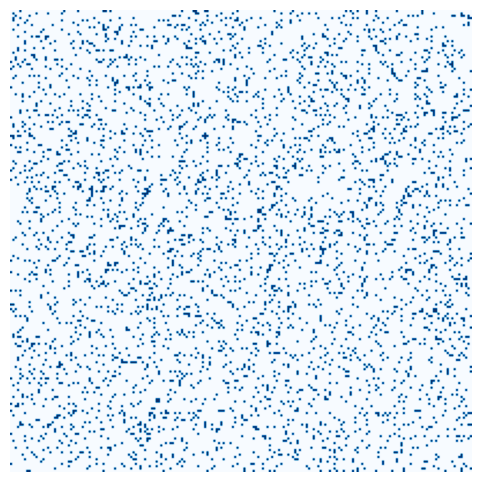

In [3]:
# Plot it
plt.figure(figsize=(6, 6))
plt.imshow(matrix, cmap='Blues')
plt.axis('off')
plt.show()

## Counting system
We need to count the number of 1s in the Moore neighborhood of each cell.

### Straight approach

In [4]:
# This function finds the neighbors of each cell
def get_neighbors(matrix, row, col, n, m):
    
    # Get the indices (the order doesn't matter)
    indices = np.array([
        #[row, col],                      # center

        [(row - 1) % n, col],            # up
        [(row + 1) % n, col],            # down
        [row, (col - 1) % m],            # left
        [row, (col + 1) % m],            # right
        
        [(row - 1) % n, (col - 1) % m],  # upper left
        [(row - 1) % n, (col + 1) % m],  # upper right
        [(row + 1) % n, (col - 1) % m],  # lower left
        [(row + 1) % n, (col + 1) % m]   # lower right
    ])
    
    # All the elements
    return matrix[indices[:,0], indices[:,1]]

In [5]:
# Test it
n, m = matrix.shape
print(get_neighbors(matrix, 2, 5, n, m))

[0 0 0 0 0 0 1 0]


Seems to be working fine. Each cell should have a value between 0 and 9.

In [6]:
# The neighbors can be obtained as
n, m = matrix.shape
neighbours = np.zeros((n, m), dtype=int)

# Start the timer
start = time.time()

# Loop over all the cells
for i in range(n):
    for j in range(m):
        neighbours[i, j] = np.sum(get_neighbors(matrix, i, j, n, m))

print(f"Elapsed time: {time.time() - start:.2f} seconds")

Elapsed time: 0.43 seconds


In [7]:
# import numpy as np
# from typing import List, Tuple, Optional

# moore_pattern = [(-1,-1), (-1,0), (-1,1),
#            (0,-1),          (0,1),
#            (1,-1),  (1,0),  (1,1)]

# def get_neighbors(matrix: np.ndarray, row: int, col: int, n: Optional[int] = None,
#                  m: Optional[int] = None, pattern: Optional[List[Tuple[int, int]]] = None) -> np.ndarray:
#     """
#     pattern: Custom neighbor pattern as [(dx,dy)], defaults to Moore neighborhood
#     """
#     # Generate indices using broadcasting
#     neighbor_indices = (np.array(pattern) + [row, col]) % [n, m]
    
#     return matrix[neighbor_indices[:,0], neighbor_indices[:,1]]

### Parallel approach
We are going to try parallelizing the counting process. We are going to use `Pool`.

In [8]:
# To count the neighbours in a portion of the matrix
def count_neighbors(args):

    # Unpack the arguments
    matrix, coords, n, m = args

    # Initialize the counts
    counts = np.zeros(len(coords), dtype = int)
    
    # Loop over the coordinates: enumerate gives the index and the value
    for i, (row, col) in enumerate(coords):

        # Get the neighbors
        neighbors = get_neighbors(matrix, row, col, n, m)

        # Count them
        counts[i] = np.sum(neighbors)
    
    return counts

The following function **splits the grid into chunks** and use the previous function to count in each.

In [9]:
# Little function
def parallel_count(matrix, num_processes = 4):

    # Get the shape of the matrix
    n, m = matrix.shape
    
    # Create all coordinates
    coords = np.array([(i, j) for i in range(n) for j in range(m)])
    
    # Split coordinates into chunks: one per processor
    coord_chunks = np.array_split(coords, num_processes)
    
    # Prepare arguments for each process
    args = [(matrix, chunk, n, m) for chunk in coord_chunks]
    
    # Pool of processors
    with Pool(num_processes) as pool:

        # Call the function for each set of coordinates
        # in parallel, and get the results
        results = pool.map(count_neighbors, args)
    
    # Combine them
    return np.concatenate(results).reshape(n, m)

In [10]:
# Test it: Start the timer
start = time.time()

# Count the neighbors
neighbours_para = parallel_count(matrix, num_processes = 4)

# Print the elapsed time
print(f"Elapsed time: {time.time() - start:.2f} s")

Elapsed time: 0.28 s


In [11]:
# Compare
np.sum(neighbours == neighbours_para)/len(neighbours.ravel())

1.0

Since results are the same, we're goint to use the parallel approach.

Before rule parsing, let's *see* the computational complexity.

#### Computational complexity
I've read its quadratic. Let's see it with both methods!

In [12]:
# # Create a empty list
# straight_list = []
# parallel_list = []

# # Set the maximum number of iterations
# max_iter = 500

# # Loop
# for i in range(2, max_iter):

#     # Create a matrix
#     matrix = np.random.choice([0, 1], size=(i, i), p=[0.8, 0.2])

#     # Get the shape of the matrix
#     n, m = matrix.shape

#     # ------------------- Parallel ----------------

#     # Start the timer
#     start = time.time()

#     # Call the parallel function
#     neighbours_parallel = parallel_count(matrix, num_processes = 4)

#     # End the timer
#     elapsed = time.time() - start

#     # --------------- Simple -------------------

#     # Create an empty matrix
#     neighbours = np.zeros((n, m), dtype=int)

#     # Start the timer
#     start2 = time.time()

#     # Loop over all the cells
#     for i in range(n):
#         for j in range(m):
#             neighbours[i, j] = np.sum(get_neighbors(matrix, i, j, n, m))
    
#     # End the timer
#     elapsed2 = time.time() - start2

#     # ------------------- Append ----------------

#     # Append the elapsed time
#     parallel_list.append(elapsed)
#     straight_list.append(elapsed2)

In [13]:
# Store them
# np.savetxt("data/parallel_list.txt", parallel_list)
# np.savetxt("data/straight_list.txt", straight_list)

# Load them
parallel_list = np.loadtxt("data/parallel_list.txt")
straight_list = np.loadtxt("data/straight_list.txt")

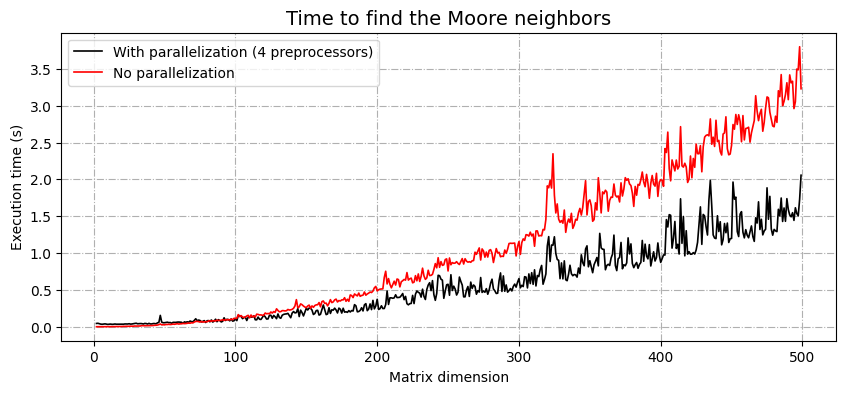

In [14]:
# Plot the results
plt.figure(figsize=(10, 4))
plt.title("Time to find the Moore neighbors", fontsize = 14)
plt.plot(np.arange(2, 500, 1), parallel_list, color = "k", label = "With parallelization (4 preprocessors)",
         lw = 1.2)
plt.plot(np.arange(2, 500, 1), straight_list, color = "red", label = "No parallelization", lw = 1.2)
plt.grid(ls = "-.", alpha = 1)

#plt.loglog()

plt.legend(fontsize = 10)
plt.xlabel("Matrix dimension")
plt.ylabel("Execution time (s)")
plt.show()

It's indeed quadratic. The parallel approach is almost twice as fast for large matrices.

## Rule parsing

In [15]:
# Little function
def get_rule(integer: int = 6152):
    
    # Convert the integer to binary (reversed)
    binary = np.binary_repr(integer, width = 18)

    # Reverse the string
    binary = binary[::-1]

    # Get the birth and survive rules
    birth = np.array([int(x) for x in binary[:9]])
    survive = np.array([int(x) for x in binary[9:]])

    # Get the indices of the 1s
    birth_rule = np.where(birth)[0]
    survive_rule = np.where(survive)[0]

    return birth_rule, survive_rule

In [16]:
# Check
print(get_rule())

(array([3]), array([2, 3]))


In [17]:
# Simple test
center_cell = 0
nbhood = 3

# Conways, Day and Night, Seeds
rules = [6152, 242120, 4]

# Loop over some integers
for i in rules:

    # Get the rules
    birth, survive = get_rule(i)

    # Apply the rules
    if (nbhood in birth) or (nbhood in survive):
        center_cell = 1

    else:
        center_cell = 0

    print(f"Rule: {i}, Center cell: {center_cell}")

Rule: 6152, Center cell: 1
Rule: 242120, Center cell: 1
Rule: 4, Center cell: 0


It works!

## Test a rule  with a matrix
We are going to test the whole process with a matrix, twice.

In [18]:
# --------------------Definitions----------------------
# Create a matrix
p = 0.5
matrix = np.random.choice([0, 1], size=(200, 200), p=[p, 1-p])

# Get the neighbors
n, m = matrix.shape

# Get the rules
rule = 5
birth, survive = get_rule(rule)

# Apply the rules
new_matrix = np.zeros((n, m), dtype = int)

# ------------------- Process 1 ----------------

# Start the timer
start = time.time()

# Get the neighbors
neighbours = parallel_count(matrix, num_processes = 4)

# Loop over all the cells
for i in range(n):
    for j in range(m):

        # Get the number of neighbors
        nbhood = neighbours[i, j]

        # Apply the rules
        if (nbhood in survive) or (nbhood in birth):
            new_matrix[i, j] = 1
        
        else:
            new_matrix[i, j] = 0

# ------------------- Process 2 ----------------

# Get the new neighbors
neighbours = parallel_count(new_matrix, num_processes = 4)

# Create another new matrix
new_matrix2 = np.zeros((n, m), dtype = int)

# Loop over all the cells
for i in range(n):
    for j in range(m):

        # Get the number of neighbors
        nbhood = neighbours[i, j]

        # Apply the rules
        if (nbhood in survive) or (nbhood in birth):
            new_matrix2[i, j] = 1
        
        else:
            new_matrix2[i, j] = 0

# Print the elapsed time
print(f"Elapsed time: {time.time() - start:.2f} s")

Elapsed time: 1.19 s


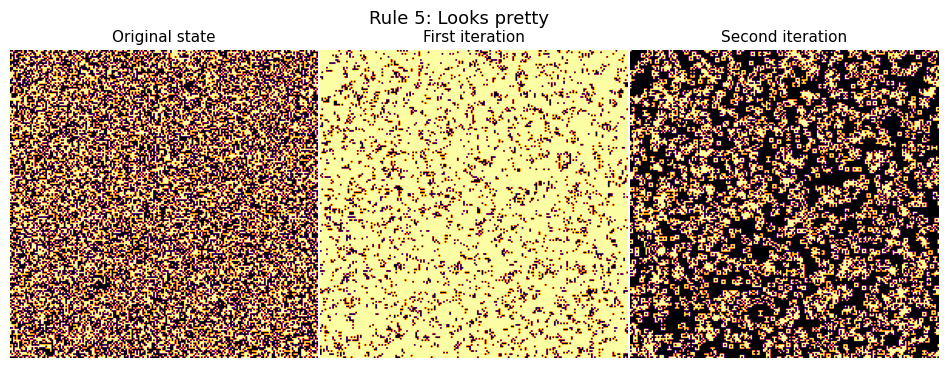

In [19]:
# Plot both matrices in a three-panel plot
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

# Title
fig.suptitle(f"Rule {rule}: Looks pretty", fontsize = 13)

# Plot the original matrix
ax[0].imshow(matrix, cmap = "inferno_r")
ax[0].set_title("Original state", fontsize = 11)

# Plot the first matrix
ax[1].imshow(new_matrix, cmap = "inferno_r")
ax[1].set_title("First iteration", fontsize = 11)

# Plot the second matrix
ax[2].imshow(new_matrix2, cmap = "inferno_r")
ax[2].set_title("Second iteration", fontsize = 11)

# Remove the axes
for a in ax:
    a.axis("off")

# Get rid of the horizontal space between subplots
plt.subplots_adjust(wspace=0)

plt.show()